In [1]:
!pip install --quiet transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


# Tokenizers library

# 1. Training a new tokenizer from an old one

⚠️ Training a tokenizer is not the same as training a model! Model training uses stochastic gradient descent to make the loss a little bit smaller for each batch. It’s randomized by nature (meaning you have to set some seeds to get the same results when doing the same training twice). Training a tokenizer is a statistical process that tries to identify which subwords are the best to pick for a given corpus, and the exact rules used to pick them depend on the tokenization algorithm. It’s deterministic, meaning you always get the same results when training with the same algorithm on the same corpus.

**Assembling a corpus**

The 🤗 Transformers library offers a simple API, `AutoTokenizer.train_new_from_iterator()`, to train a new tokenizer based on the characteristics of an existing one. For example, to train GPT-2 from scratch in a non-English language, you need a large training corpus in that language. To make this understandable, the example uses Python code as the language. The 🤗 Datasets library can be used to gather a corpus of Python code. By using the `load_dataset()` function, you can download and cache the CodeSearchNet dataset, which contains millions of functions from open-source libraries on GitHub. For this example, only the Python portion of the dataset will be loaded.

In [ ]:
from datasets import load_dataset

# This can take a few minutes to load, so grab a coffee or tea while you wait!
raw_datasets = load_dataset("code_search_net", "python")
raw_datasets["train"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

Dataset({
    features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
    num_rows: 412178
})

We can see the dataset separates docstrings from code and suggests a tokenization of both. Here. we’ll just use the whole_func_string column to train our tokenizer. We can look at an example of one these functions by indexing into the train split:



In [ ]:
print(raw_datasets["train"][123456]["whole_func_string"])

def cleanup_sweep_threads():
    '''
    Not used. Keeping this function in case we decide not to use
    daemonized threads and it becomes necessary to clean up the
    running threads upon exit.
    '''

    for dict_name, obj in globals().items():
        if isinstance(obj, (TimedDict,)):
            logging.info(
                'Stopping thread for TimedDict {dict_name}'.format(
                    dict_name=dict_name))
            obj.stop_sweep()


The first thing we need to do is transform the dataset into an iterator of lists of texts — for instance, a list of list of texts. Using lists of texts will enable our tokenizer to go faster (training on batches of texts instead of processing individual texts one by one), and it should be an iterator if we want to avoid having everything in memory at once. If your corpus is huge, you will want to take advantage of the fact that 🤗 Datasets does not load everything into RAM but stores the elements of the dataset on disk.

Doing the following would create a list of lists of 1,000 texts each, but would load everything in memory:



```
# Don't uncomment the following line unless your dataset is small!
# training_corpus = [raw_datasets["train"][i: i + 1000]["whole_func_string"] for i in range(0, len(raw_datasets["train"]), 1000)]
```

Using a Python generator, we can avoid Python loading anything into memory until it’s actually necessary. To create such a generator, you just to need to replace the brackets with parentheses:



In [ ]:
training_corpus = (
    raw_datasets["train"][i : i + 1000]["whole_func_string"]
    for i in range(0, len(raw_datasets["train"]), 1000)
)

This line of code doesn’t fetch any elements of the dataset; it just creates an object you can use in a Python for loop. The texts will only be loaded when you need them (that is, when you’re at the step of the for loop that requires them), and only 1,000 texts at a time will be loaded. This way you won’t exhaust all your memory even if you are processing a huge dataset.

The problem with a generator object is that it can only be used once. So, instead of this giving us the list of the first 10 digits twice:

In [ ]:
gen = (i for i in range(10))
print(list(gen))
print(list(gen))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[]


That’s why we define a function that returns a generator instead:



In [ ]:
def get_training_corpus():
    return (
        raw_datasets["train"][i : i + 1000]["whole_func_string"]
        for i in range(0, len(raw_datasets["train"]), 1000)
    )


training_corpus = get_training_corpus()

You can also define your generator inside a for loop by using the yield statement:



In [ ]:
def get_training_corpus():
    dataset = raw_datasets["train"]
    for start_idx in range(0, len(dataset), 1000):
        samples = dataset[start_idx : start_idx + 1000]
        yield samples["whole_func_string"]

which will produce the exact same generator as before, but allows you to use more complex logic than you can in a list comprehension.



**Training a new tokenizer**

Now that we have our corpus in the form of an iterator of batches of texts, we are ready to train a new tokenizer. To do this, we first need to load the tokenizer we want to pair with our model (here, GPT-2):



In [ ]:
from transformers import AutoTokenizer

old_tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Even though we are going to train a new tokenizer, it’s a good idea to do this to avoid starting entirely from scratch. This way, we won’t have to specify anything about the tokenization algorithm or the special tokens we want to use; our new tokenizer will be exactly the same as GPT-2, and the only thing that will change is the vocabulary, which will be determined by the training on our corpus.

First let’s have a look at how this tokenizer would treat an example function:

In [ ]:
example = '''def add_numbers(a, b):
    """Add the two numbers `a` and `b`."""
    return a + b'''

tokens = old_tokenizer.tokenize(example)
tokens

['def',
 'Ġadd',
 '_',
 'n',
 'umbers',
 '(',
 'a',
 ',',
 'Ġb',
 '):',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġ"""',
 'Add',
 'Ġthe',
 'Ġtwo',
 'Ġnumbers',
 'Ġ`',
 'a',
 '`',
 'Ġand',
 'Ġ`',
 'b',
 '`',
 '."',
 '""',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġreturn',
 'Ġa',
 'Ġ+',
 'Ġb']

This tokenizer has a few special symbols, like Ġ and Ċ, which denote spaces and newlines, respectively. As we can see, this is not too efficient: the tokenizer returns individual tokens for each space, when it could group together indentation levels (since having sets of four or eight spaces is going to be very common in code). It also split the function name a bit weirdly, not being used to seeing words with the _ character.

Let’s train a new tokenizer and see if it solves those issues. For this, we’ll use the method train_new_from_iterator():

In [ ]:
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 52000)

Training a new tokenizer using the AutoTokenizer.train_new_from_iterator() function is efficient even for large datasets. For instance, a 1.6 GB dataset was processed in just 1 minute 16 seconds on a 12-core AMD Ryzen 9 3900X CPU.

This function works only with "fast" tokenizers, which are backed by the 🤗 Tokenizers library written in Rust, unlike the slower pure Python tokenizers. Rust's parallelization capabilities make it much faster for tasks such as training new tokenizers, similar to how CUDA optimizes GPU computations for deep learning.

The 🤗 Tokenizers library provides Python bindings, so you don’t need to learn Rust to use fast tokenizers. The AutoTokenizer API automatically selects the fast tokenizer when available. Most Transformer models have fast tokenizers, which offer additional features useful for tasks like token classification and question answering. Next, we will test our new tokenizer on a previous example.

In [ ]:
tokens = tokenizer.tokenize(example)
tokens

['def',
 'Ġadd',
 '_',
 'numbers',
 '(',
 'a',
 ',',
 'Ġb',
 '):',
 'ĊĠĠĠ',
 'Ġ"""',
 'Add',
 'Ġthe',
 'Ġtwo',
 'Ġnumbers',
 'Ġ`',
 'a',
 '`',
 'Ġand',
 'Ġ`',
 'b',
 '`."""',
 'ĊĠĠĠ',
 'Ġreturn',
 'Ġa',
 'Ġ+',
 'Ġb']

Here we again see the special symbols Ġ and Ċ that denote spaces and newlines, but we can also see that our tokenizer learned some tokens that are highly specific to a corpus of Python functions: for example, there is a ĊĠĠĠ token that represents an indentation, and a Ġ""" token that represents the three quotes that start a docstring. The tokenizer also correctly split the function name on _. This is quite a compact representation; comparatively, using the plain English tokenizer on the same example will give us a longer sentence:

In [ ]:
print(len(tokens))
print(len(old_tokenizer.tokenize(example)))

27
36


In [ ]:
# lets look at another example
example = """class LinearLayer():
    def __init__(self, input_size, output_size):
        self.weight = torch.randn(input_size, output_size)
        self.bias = torch.zeros(output_size)

    def __call__(self, x):
        return x @ self.weights + self.bias
    """
tokenizer.tokenize(example)

['class',
 'ĠLinear',
 'Layer',
 '():',
 'ĊĠĠĠ',
 'Ġdef',
 'Ġ__',
 'init',
 '__(',
 'self',
 ',',
 'Ġinput',
 '_',
 'size',
 ',',
 'Ġoutput',
 '_',
 'size',
 '):',
 'ĊĠĠĠĠĠĠĠ',
 'Ġself',
 '.',
 'weight',
 'Ġ=',
 'Ġtorch',
 '.',
 'randn',
 '(',
 'input',
 '_',
 'size',
 ',',
 'Ġoutput',
 '_',
 'size',
 ')',
 'ĊĠĠĠĠĠĠĠ',
 'Ġself',
 '.',
 'bias',
 'Ġ=',
 'Ġtorch',
 '.',
 'zeros',
 '(',
 'output',
 '_',
 'size',
 ')',
 'ĊĊĠĠĠ',
 'Ġdef',
 'Ġ__',
 'call',
 '__(',
 'self',
 ',',
 'Ġx',
 '):',
 'ĊĠĠĠĠĠĠĠ',
 'Ġreturn',
 'Ġx',
 'Ġ@',
 'Ġself',
 '.',
 'weights',
 'Ġ+',
 'Ġself',
 '.',
 'bias',
 'ĊĠĠĠĠ']

In addition to the token corresponding to an indentation, here we can also see a token for a double indentation: ĊĠĠĠĠĠĠĠ. The special Python words like class, init, call, self, and return are each tokenized as one token, and we can see that as well as splitting on _ and . the tokenizer correctly splits even camel-cased names: LinearLayer is tokenized as ["ĠLinear", "Layer"].



**Saving the tokenizer**

To make sure we can use it later, we need to save our new tokenizer. Like for models, this is done with the save_pretrained() method:



In [ ]:
tokenizer.save_pretrained("code-search-net-tokenizer")

('code-search-net-tokenizer/tokenizer_config.json',
 'code-search-net-tokenizer/special_tokens_map.json',
 'code-search-net-tokenizer/vocab.json',
 'code-search-net-tokenizer/merges.txt',
 'code-search-net-tokenizer/added_tokens.json',
 'code-search-net-tokenizer/tokenizer.json')

This will create a new folder named code-search-net-tokenizer, which will contain all the files the tokenizer needs to be reloaded. If you want to share this tokenizer with your colleagues and friends, you can upload it to the Hub by logging into your account. If you’re working in a notebook, there’s a convenience function to help you with this:



In [ ]:
from huggingface_hub import notebook_login

notebook_login()

This will display a widget where you can enter your Hugging Face login credentials. If you aren’t working in a notebook, just type the following line in your terminal:



In [ ]:
huggingface-cli login

Once you’ve logged in, you can push your tokenizer by executing the following command:



In [ ]:
tokenizer.push_to_hub("code-search-net-tokenizer")

This will create a new repository in your namespace with the name code-search-net-tokenizer, containing the tokenizer file. You can then load the tokenizer from anywhere with the from_pretrained() method:



In [ ]:
# Replace "huggingface-course" below with your actual namespace to use your own tokenizer
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

tokenizer_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/789k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/448k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

# 2. Fast tokenizers' special powers

Slow tokenizers are those written in Python inside the 🤗 Transformers library, while the fast versions are the ones provided by 🤗 Tokenizers, which are written in Rust.

⚠️ When tokenizing a single sentence, you won’t always see a difference in speed between the slow and fast versions of the same tokenizer. In fact, the fast version might actually be slower! It’s only when tokenizing lots of texts in parallel at the same time that you will be able to clearly see the difference.

**Batch encoding**

The output of a tokenizer is a special BatchEncoding object, not a simple Python dictionary. Although it can be indexed like a dictionary, it includes additional methods mainly used by fast tokenizers. These tokenizers excel in parallelization and maintain an offset mapping, tracking the original text spans from which tokens are derived. This allows for features such as mapping words to their generated tokens and mapping characters of the original text to the tokens they belong to, and vice versa.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
encoding = tokenizer(example)
print(type(encoding))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

<class 'transformers.tokenization_utils_base.BatchEncoding'>


As mentioned previously, we get a BatchEncoding object in the tokenizer’s output:

`<class 'transformers.tokenization_utils_base.BatchEncoding'>`

Since the AutoTokenizer class picks a fast tokenizer by default, we can use the additional methods this BatchEncoding object provides. We have two ways to check if our tokenizer is a fast or a slow one. We can either check the attribute is_fast of the tokenizer:

In [ ]:
tokenizer.is_fast

True

or check the same attribute of our encoding:



In [ ]:
encoding.is_fast

True

Let’s see what a fast tokenizer enables us to do. First, we can access the tokens without having to convert the IDs back to tokens:



In [ ]:
encoding.tokens()

['[CLS]',
 'My',
 'name',
 'is',
 'S',
 '##yl',
 '##va',
 '##in',
 'and',
 'I',
 'work',
 'at',
 'Hu',
 '##gging',
 'Face',
 'in',
 'Brooklyn',
 '.',
 '[SEP]']

In this case the token at index 5 is ##yl, which is part of the word “Sylvain” in the original sentence. We can also use the word_ids() method to get the index of the word each token comes from:



In [ ]:
encoding.word_ids()

[None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, None]

The tokenizer’s special tokens [CLS] and [SEP] are mapped to None, and each token is mapped to its originating word. This helps determine if a token starts a word or if multiple tokens belong to the same word, a method that works with any fast tokenizer. This capability is crucial for tasks like named entity recognition (NER) and part-of-speech (POS) tagging, as well as techniques like whole word masking in masked language modeling.

The concept of a word can vary by tokenizer, such as how contractions like “I’ll” are treated, which depends on the tokenizer’s pre-tokenization operation. Tokenizers may split words differently based on spaces or punctuation.

Additionally, methods like sentence_ids() help map tokens to their sentences. Methods like word_to_chars(), token_to_chars(), char_to_word(), and char_to_token() allow mapping between words or tokens and their characters in the original text. For example, word_ids() can identify which word a token like ##yl belongs to in a sentence.

In [ ]:
start, end = encoding.word_to_chars(3)
example[start:end]

'Sylvain'

As we mentioned previously, this is all powered by the fact the fast tokenizer keeps track of the span of text each token comes from in a list of offsets. To illustrate their use, next we’ll show you how to replicate the results of the token-classification pipeline manually.

**Inside the token-classification pipeline**

**Gettting the base resuls with the pipeline**

First, let’s grab a token classification pipeline so we can get some results to compare manually. The model used by default is dbmdz/bert-large-cased-finetuned-conll03-english; it performs NER on sentences:



In [ ]:
from transformers import pipeline

token_classifier = pipeline("token-classification")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

[{'entity': 'I-PER',
  'score': 0.99938285,
  'index': 4,
  'word': 'S',
  'start': 11,
  'end': 12},
 {'entity': 'I-PER',
  'score': 0.99815494,
  'index': 5,
  'word': '##yl',
  'start': 12,
  'end': 14},
 {'entity': 'I-PER',
  'score': 0.99590707,
  'index': 6,
  'word': '##va',
  'start': 14,
  'end': 16},
 {'entity': 'I-PER',
  'score': 0.99923277,
  'index': 7,
  'word': '##in',
  'start': 16,
  'end': 18},
 {'entity': 'I-ORG',
  'score': 0.9738931,
  'index': 12,
  'word': 'Hu',
  'start': 33,
  'end': 35},
 {'entity': 'I-ORG',
  'score': 0.97611517,
  'index': 13,
  'word': '##gging',
  'start': 35,
  'end': 40},
 {'entity': 'I-ORG',
  'score': 0.9887976,
  'index': 14,
  'word': 'Face',
  'start': 41,
  'end': 45},
 {'entity': 'I-LOC',
  'score': 0.9932106,
  'index': 16,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

The model properly identified each token generated by “Sylvain” as a person, each token generated by “Hugging Face” as an organization, and the token “Brooklyn” as a location. We can also ask the pipeline to group together the tokens that correspond to the same entity:



In [ ]:
from transformers import pipeline

token_classifier = pipeline("token-classification", aggregation_strategy="simple")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity_group': 'PER',
  'score': 0.9981694,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.9796019,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.9932106,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

The aggregation strategy chosen affects the scores computed for each grouped entity. The available strategies are:

- **"simple"**: The score is the mean of the scores of each token in the entity.
- **"first"**: The score is the score of the first token in the entity.
- **"max"**: The score is the maximum score among the tokens in the entity.
- **"average"**: The score is the average of the scores of the words composing the entity.

For example, using the "simple" strategy, the score for "Sylvain" is the mean of its token scores. With the "first" strategy, the score for "Sylvain" is the score of the token 'S'. With the "max" strategy, the score for "Hugging Face" is the highest token score among its tokens. With the "average" strategy, the score for "Hugging Face" is the average of the scores for "Hugging" and "Face".

**From inputs to predictions**

First we need to tokenize our input and pass it through the model. This is done exactly as in Chapter 2; we instantiate the tokenizer and the model using the AutoXxx classes and then use them on our example:



In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
inputs = tokenizer(example, return_tensors="pt")
outputs = model(**inputs)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Since we’re using AutoModelForTokenClassification here, we get one set of logits for each token in the input sequence:



In [ ]:
print(inputs["input_ids"].shape)
print(outputs.logits.shape)

torch.Size([1, 19])
torch.Size([1, 19, 9])


We have a batch with 1 sequence of 19 tokens and the model has 9 different labels, so the output of the model has a shape of 1 x 19 x 9. Like for the text classification pipeline, we use a softmax function to convert those logits to probabilities, and we take the argmax to get predictions (note that we can take the argmax on the logits because the softmax does not change the order):



In [ ]:
import torch

probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
predictions = outputs.logits.argmax(dim=-1)[0].tolist()
print(predictions)

[0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 6, 6, 6, 0, 8, 0, 0]


The model.config.id2label attribute contains the mapping of indexes to labels that we can use to make sense of the predictions:



In [ ]:
model.config.id2label

{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

There are 9 labels for named entity recognition: "O" for tokens outside any entity, and "B-XXX" and "I-XXX" for the beginning and inside of entities (miscellaneous, person, organization, and location). For example, "B-PER" indicates the beginning of a person entity, and "I-PER" indicates inside a person entity.

The model might label all tokens in "Sylvain" as "I-PER" due to using the IOB1 format, where "B-" labels are only used to separate adjacent entities of the same type. The IOB2 format, introduced earlier, uses "B-" labels at the start of any entity. The model was trained on a dataset using IOB1, explaining its labeling.

![](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter6/IOB_versions-dark.svg)

With this understanding, we can reproduce the results by obtaining the score and label for each token not classified as "O".

In [ ]:
results = []
tokens = inputs.tokens()

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        results.append(
            {"entity": label, "score": probabilities[idx][pred], "word": tokens[idx]}
        )

print(results)

[{'entity': 'I-PER', 'score': 0.9993828535079956, 'word': 'S'}, {'entity': 'I-PER', 'score': 0.9981549382209778, 'word': '##yl'}, {'entity': 'I-PER', 'score': 0.9959070682525635, 'word': '##va'}, {'entity': 'I-PER', 'score': 0.9992327690124512, 'word': '##in'}, {'entity': 'I-ORG', 'score': 0.9738932251930237, 'word': 'Hu'}, {'entity': 'I-ORG', 'score': 0.9761151671409607, 'word': '##gging'}, {'entity': 'I-ORG', 'score': 0.9887976050376892, 'word': 'Face'}, {'entity': 'I-LOC', 'score': 0.9932106137275696, 'word': 'Brooklyn'}]


This is very similar to what we had before, with one exception: the pipeline also gave us information about the start and end of each entity in the original sentence. This is where our offset mapping will come into play. To get the offsets, we just have to set return_offsets_mapping=True when we apply the tokenizer to our inputs:



In [ ]:
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
inputs_with_offsets["offset_mapping"]

[(0, 0),
 (0, 2),
 (3, 7),
 (8, 10),
 (11, 12),
 (12, 14),
 (14, 16),
 (16, 18),
 (19, 22),
 (23, 24),
 (25, 29),
 (30, 32),
 (33, 35),
 (35, 40),
 (41, 45),
 (46, 48),
 (49, 57),
 (57, 58),
 (0, 0)]

Each tuple is the span of text corresponding to each token, where (0, 0) is reserved for the special tokens. We saw before that the token at index 5 is ##yl, which has (12, 14) as offsets here. If we grab the corresponding slice in our example:



we get the proper span of text without the ##:



In [ ]:
example[12:14]

'yl'

Using this, we can now complete the previous results:



In [ ]:
results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        start, end = offsets[idx]
        results.append(
            {
                "entity": label,
                "score": probabilities[idx][pred],
                "word": tokens[idx],
                "start": start,
                "end": end,
            }
        )

print(results)

[{'entity': 'I-PER', 'score': 0.9993828535079956, 'word': 'S', 'start': 11, 'end': 12}, {'entity': 'I-PER', 'score': 0.9981549382209778, 'word': '##yl', 'start': 12, 'end': 14}, {'entity': 'I-PER', 'score': 0.9959070682525635, 'word': '##va', 'start': 14, 'end': 16}, {'entity': 'I-PER', 'score': 0.9992327690124512, 'word': '##in', 'start': 16, 'end': 18}, {'entity': 'I-ORG', 'score': 0.9738932251930237, 'word': 'Hu', 'start': 33, 'end': 35}, {'entity': 'I-ORG', 'score': 0.9761151671409607, 'word': '##gging', 'start': 35, 'end': 40}, {'entity': 'I-ORG', 'score': 0.9887976050376892, 'word': 'Face', 'start': 41, 'end': 45}, {'entity': 'I-LOC', 'score': 0.9932106137275696, 'word': 'Brooklyn', 'start': 49, 'end': 57}]


This is the same as what we got from the first pipeline!



**Grouping entities**

Using offsets to determine the start and end of each entity simplifies the process of grouping tokens. Without offsets, custom rules would be needed to handle token grouping, which would vary by tokenizer type. For example, grouping "Hu", "##gging", and "Face" requires different rules depending on the tokenizer. Offsets eliminate this complexity by allowing us to directly reference the span in the original text, simplifying the grouping process across different tokenizers.

In [ ]:
example[33:45]

'Hugging Face'

To write the code that post-processes the predictions while grouping entities, we will group together entities that are consecutive and labeled with I-XXX, except for the first one, which can be labeled as B-XXX or I-XXX (so, we stop grouping an entity when we get a O, a new type of entity, or a B-XXX that tells us an entity of the same type is starting):



In [ ]:
import numpy as np

results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

idx = 0
while idx < len(predictions):
    pred = predictions[idx]
    label = model.config.id2label[pred]
    if label != "O":
        # Remove the B- or I-
        label = label[2:]
        start, _ = offsets[idx]

        # Grab all the tokens labeled with I-label
        all_scores = []
        while (
            idx < len(predictions)
            and model.config.id2label[predictions[idx]] == f"I-{label}"
        ):
            all_scores.append(probabilities[idx][pred])
            _, end = offsets[idx]
            idx += 1

        # The score is the mean of all the scores of the tokens in that grouped entity
        score = np.mean(all_scores).item()
        word = example[start:end]
        results.append(
            {
                "entity_group": label,
                "score": score,
                "word": word,
                "start": start,
                "end": end,
            }
        )
    idx += 1

print(results)

[{'entity_group': 'PER', 'score': 0.998169407248497, 'word': 'Sylvain', 'start': 11, 'end': 18}, {'entity_group': 'ORG', 'score': 0.9796019991238912, 'word': 'Hugging Face', 'start': 33, 'end': 45}, {'entity_group': 'LOC', 'score': 0.9932106137275696, 'word': 'Brooklyn', 'start': 49, 'end': 57}]


And we get the same results as with our second pipeline!

Another example of a task where these offsets are extremely useful is question answering. Diving into that pipeline, which we’ll do in the next section, will also enable us to take a look at one last feature of the tokenizers in the 🤗 Transformers library: dealing with overflowing tokens when we truncate an input to a given length.

# 3. Fast tokenizers in the QA pipeline

**Using the QA pipeline**



In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch, and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'score': 0.9802601933479309,
 'start': 78,
 'end': 106,
 'answer': 'Jax, PyTorch, and TensorFlow'}

Unlike the other pipelines, which can’t truncate and split texts that are longer than the maximum length accepted by the model (and thus may miss information at the end of a document), this pipeline can deal with very long contexts and will return the answer to the question even if it’s at the end:



In [ ]:
long_context = """
🤗 Transformers: State of the Art NLP

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified API for using all our pretrained models.
  - Lower compute costs, smaller carbon footprint:

2. Researchers can share trained models instead of always retraining.
  - Practitioners can reduce compute time and production costs.
  - Dozens of architectures with over 10,000 pretrained models, some in more than 100 languages.

3. Choose the right framework for every part of a model's lifetime:
  - Train state-of-the-art models in 3 lines of code.
  - Move a single model between TF2.0/PyTorch frameworks at will.
  - Seamlessly pick the right framework for training, evaluation and production.

4. Easily customize a model or an example to your needs:
  - We provide examples for each architecture to reproduce the results published by its original authors.
  - Model internals are exposed as consistently as possible.
  - Model files can be used independently of the library for quick experiments.

🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question_answerer(question=question, context=long_context)

{'score': 0.9714872241020203,
 'start': 1892,
 'end': 1919,
 'answer': 'Jax, PyTorch and TensorFlow'}

**Using a model for QA**

Like with any other pipeline, we start by tokenizing our input and then send it through the model. The checkpoint used by default for the question-answering pipeline is distilbert-base-cased-distilled-squad (the “squad” in the name comes from the dataset on which the model was fine-tuned; we’ll talk more about the SQuAD dataset)

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

model_checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="pt")
outputs = model(**inputs)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

Note that we tokenize the question and the context as a pair, with the question first.

![](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter6/question_tokens-dark.svg)

Models for question answering work a little differently from the models we’ve seen up to now. Using the picture above as an example, the model has been trained to predict the index of the token starting the answer (here 21) and the index of the token where the answer ends (here 24). This is why those models don’t return one tensor of logits but two: one for the logits corresponding to the start token of the answer, and one for the logits corresponding to the end token of the answer. Since in this case we have only one input containing 66 tokens, we get:



In [ ]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([1, 67]) torch.Size([1, 67])


To convert those logits into probabilities, we will apply a softmax function — but before that, we need to make sure we mask the indices that are not part of the context. Our input is [CLS] question [SEP] context [SEP], so we need to mask the tokens of the question as well as the [SEP] token. We’ll keep the [CLS] token, however, as some models use it to indicate that the answer is not in the context.

Since we will apply a softmax afterward, we just need to replace the logits we want to mask with a large negative number. Here, we use -10000:

In [ ]:
import torch

sequence_ids = inputs.sequence_ids()
# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Unmask the [CLS] token
mask[0] = False
mask = torch.tensor(mask)[None]

start_logits[mask] = -10000
end_logits[mask] = -10000

Now that we have properly masked the logits corresponding to positions we don’t want to predict, we can apply the softmax:



In [ ]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)[0]
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)[0]

At this stage, instead of simply taking the argmax of the start and end probabilities (which could result in an invalid range), we should consider all possible (start_index, end_index) pairs where start_index <= end_index. We then select the tuple with the highest probability.

Assuming the events "The answer starts at start_index" and "The answer ends at end_index" are independent, the probability for a specific pair is given by the product of their individual probabilities:
$ \text{start_probabilities[start_index]} \times \text{end_probabilities[end_index]} $

To find the best (start_index, end_index) pair, we compute these products for all valid pairs and select the one with the highest score.

In [ ]:
scores = start_probabilities[:, None] * end_probabilities[None, :]

Then we’ll mask the values where start_index > end_index by setting them to 0 (the other probabilities are all positive numbers). The torch.triu() function returns the upper triangular part of the 2D tensor passed as an argument, so it will do that masking for us:



In [ ]:
scores = torch.triu(scores)

Now we just have to get the index of the maximum. Since PyTorch will return the index in the flattened tensor, we need to use the floor division // and modulus % operations to get the start_index and end_index:



In [ ]:
max_index = scores.argmax().item()
start_index = max_index // scores.shape[1]
end_index = max_index % scores.shape[1]
print(scores[start_index, end_index])

tensor(0.9803, grad_fn=<SelectBackward0>)


We have the start_index and end_index of the answer in terms of tokens, so now we just need to convert to the character indices in the context. This is where the offsets will be super useful. We can grab them and use them like we did in the token classification task:



In [ ]:
inputs_with_offsets = tokenizer(question, context, return_offsets_mapping=True)
offsets = inputs_with_offsets["offset_mapping"]

start_char, _ = offsets[start_index]
_, end_char = offsets[end_index]
answer = context[start_char:end_char]

Now we just have to format everything to get our result:



In [ ]:
result = {
    "answer": answer,
    "start": start_char,
    "end": end_char,
    "score": scores[start_index, end_index],
}
print(result)

{'answer': 'Jax, PyTorch, and TensorFlow', 'start': 78, 'end': 106, 'score': tensor(0.9803, grad_fn=<SelectBackward0>)}


Great! That’s the same as in our first example!



**Handling long contexts**

If we try to tokenize the question and long context we used as an example previously, we’ll get a number of tokens higher than the maximum length used in the question-answering pipeline (which is 384):



In [ ]:
inputs = tokenizer(question, long_context)
print(len(inputs["input_ids"]))

461


So, we’ll need to truncate our inputs at that maximum length. There are several ways we can do this, but we don’t want to truncate the question, only the context. Since the context is the second sentence, we’ll use the "only_second" truncation strategy. The problem that arises then is that the answer to the question may not be in the truncated context. Here, for instance, we picked a question where the answer is toward the end of the context, and when we truncate it that answer is not present:



In [ ]:
inputs = tokenizer(question, long_context, max_length=384, truncation="only_second")
print(tokenizer.decode(inputs["input_ids"]))

[CLS] Which deep learning libraries back [UNK] Transformers? [SEP] [UNK] Transformers : State of the Art NLP [UNK] Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction, question answering, summarization, translation, text generation and more in over 100 languages. Its aim is to make cutting - edge NLP easier to use for everyone. [UNK] Transformers provides APIs to quickly download and use those pretrained models on a given text, fine - tune them on your own datasets and then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and can be modified to enable quick research experiments. Why should I use transformers? 1. Easy - to - use state - of - the - art models : - High performance on NLU and NLG tasks. - Low barrier to entry for educators and practitioners. - Few user - facing abstractions with just three classes to learn. - A unified A

This means the model will have a hard time picking the correct answer. To fix this, the question-answering pipeline allows us to split the context into smaller chunks, specifying the maximum length. To make sure we don’t split the context at exactly the wrong place to make it possible to find the answer, it also includes some overlap between the chunks.

We can have the tokenizer (fast or slow) do this for us by adding return_overflowing_tokens=True, and we can specify the overlap we want with the stride argument. Here is an example, using a smaller sentence:

In [ ]:
sentence = "This sentence is not too long but we are going to split it anyway."
inputs = tokenizer(
    sentence, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] This sentence is not [SEP]
[CLS] is not too long [SEP]
[CLS] too long but we [SEP]
[CLS] but we are going [SEP]
[CLS] are going to split [SEP]
[CLS] to split it anyway [SEP]
[CLS] it anyway. [SEP]


As we can see, the sentence has been split into chunks in such a way that each entry in inputs["input_ids"] has at most 6 tokens (we would need to add padding to have the last entry be the same size as the others) and there is an overlap of 2 tokens between each of the entries.

Let’s take a closer look at the result of the tokenization:

In [ ]:
print(inputs.keys())

dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping'])


As expected, we get input IDs and an attention mask. The last key, overflow_to_sample_mapping, is a map that tells us which sentence each of the results corresponds to — here we have 7 results that all come from the (only) sentence we passed the tokenizer:



In [ ]:
print(inputs["overflow_to_sample_mapping"])

[0, 0, 0, 0, 0, 0, 0]


This is more useful when we tokenize several sentences together. For instance, this:



In [ ]:
sentences = [
    "This sentence is not too long but we are going to split it anyway.",
    "This sentence is shorter but will still get split.",
]
inputs = tokenizer(
    sentences, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2
)

print(inputs["overflow_to_sample_mapping"])

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


which means the first sentence is split into 7 chunks as before, and the next 4 chunks come from the second sentence.

Now let’s go back to our long context. By default the question-answering pipeline uses a maximum length of 384, as we mentioned earlier, and a stride of 128, which correspond to the way the model was fine-tuned (you can adjust those parameters by passing max_seq_len and stride arguments when calling the pipeline). We will thus use those parameters when tokenizing. We’ll also add padding (to have samples of the same length, so we can build tensors) as well as ask for the offsets:

In [ ]:
inputs = tokenizer(
    question,
    long_context,
    stride=128,
    max_length=384,
    padding="longest",
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

Those inputs will contain the input IDs and attention masks the model expects, as well as the offsets and the overflow_to_sample_mapping we just talked about. Since those two are not parameters used by the model, we’ll pop them out of the inputs (and we won’t store the map, since it’s not useful here) before converting it to a tensor:



In [ ]:
_ = inputs.pop("overflow_to_sample_mapping")
offsets = inputs.pop("offset_mapping")

inputs = inputs.convert_to_tensors("pt")
print(inputs["input_ids"].shape)

torch.Size([2, 384])


Our long context was split in two, which means that after it goes through our model, we will have two sets of start and end logits:



In [ ]:
outputs = model(**inputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([2, 384]) torch.Size([2, 384])


Like before, we first mask the tokens that are not part of the context before taking the softmax. We also mask all the padding tokens (as flagged by the attention mask):



In [ ]:
sequence_ids = inputs.sequence_ids()
# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Unmask the [CLS] token
mask[0] = False
# Mask all the [PAD] tokens
mask = torch.logical_or(torch.tensor(mask)[None], (inputs["attention_mask"] == 0))

start_logits[mask] = -10000
end_logits[mask] = -10000

Then we can use the softmax to convert our logits to probabilities:



In [ ]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)

The next step is similar to what we did for the small context, but we repeat it for each of our two chunks. We attribute a score to all possible spans of answer, then take the span with the best score:



In [ ]:
candidates = []
for start_probs, end_probs in zip(start_probabilities, end_probabilities):
    scores = start_probs[:, None] * end_probs[None, :]
    idx = torch.triu(scores).argmax().item()

    start_idx = idx // scores.shape[1]
    end_idx = idx % scores.shape[1]
    score = scores[start_idx, end_idx].item()
    candidates.append((start_idx, end_idx, score))

print(candidates)

[(0, 18, 0.33867043256759644), (173, 184, 0.9714869856834412)]


Those two candidates correspond to the best answers the model was able to find in each chunk. The model is way more confident the right answer is in the second part (which is a good sign!). Now we just have to map those two token spans to spans of characters in the context (we only need to map the second one to have our answer, but it’s interesting to see what the model has picked in the first chunk).

The offsets we grabbed earlier is actually a list of offsets, with one list per chunk of text:



In [ ]:
for candidate, offset in zip(candidates, offsets):
    start_token, end_token, score = candidate
    start_char, _ = offset[start_token]
    _, end_char = offset[end_token]
    answer = long_context[start_char:end_char]
    result = {"answer": answer, "start": start_char, "end": end_char, "score": score}
    print(result)

{'answer': '\n🤗 Transformers: State of the Art NLP', 'start': 0, 'end': 37, 'score': 0.33867043256759644}
{'answer': 'Jax, PyTorch and TensorFlow', 'start': 1892, 'end': 1919, 'score': 0.9714869856834412}


If we ignore the first result, we get the same result as our pipeline for this long context — yay!

This concludes our deep dive into the tokenizer’s capabilities.

# 4. Normalization and pre-tokenization

![](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter6/tokenization_pipeline-dark.svg)

Before splitting a text into subtokens (according to its model), the tokenizer performs two steps: normalization and pre-tokenization.



**Normalization**

The normalization step involves some general cleanup, such as removing needless whitespace, lowercasing, and/or removing accents. If you’re familiar with [Unicode normalization](https://www.unicode.org/reports/tr15/) (such as NFC or NFKC), this is also something the tokenizer may apply.

The 🤗 Transformers tokenizer has an attribute called backend_tokenizer that provides access to the underlying tokenizer from the 🤗 Tokenizers library:

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(type(tokenizer.backend_tokenizer))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<class 'tokenizers.Tokenizer'>


The normalizer attribute of the tokenizer object has a normalize_str() method that we can use to see how the normalization is performed:



In [ ]:
print(tokenizer.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

hello how are u?


In this example, since we picked the bert-base-uncased checkpoint, the normalization applied lowercasing and removed the accents.



**Pre-tokenization**

As we will see in the next sections, a tokenizer cannot be trained on raw text alone. Instead, we first need to split the texts into small entities, like words. That’s where the pre-tokenization step comes in. As we saw in Chapter 2, a word-based tokenizer can simply split a raw text into words on whitespace and punctuation. Those words will be the boundaries of the subtokens the tokenizer can learn during its training.

To see how a fast tokenizer performs pre-tokenization, we can use the pre_tokenize_str() method of the pre_tokenizer attribute of the tokenizer object:

In [ ]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('how', (7, 10)),
 ('are', (11, 14)),
 ('you', (16, 19)),
 ('?', (19, 20))]

Notice how the tokenizer is already keeping track of the offsets, which is how it can give us the offset mapping we used in the previous section. Here the tokenizer ignores the two spaces and replaces them with just one, but the offset jumps between are and you to account for that.

Since we’re using a BERT tokenizer, the pre-tokenization involves splitting on whitespace and punctuation. Other tokenizers can have different rules for this step. For example, if we use the GPT-2 tokenizer:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('Ġhow', (6, 10)),
 ('Ġare', (10, 14)),
 ('Ġ', (14, 15)),
 ('Ġyou', (15, 19)),
 ('?', (19, 20))]

it will split on whitespace and punctuation as well, but it will keep the spaces and replace them with a Ġ symbol, enabling it to recover the original spaces if we decode the tokens:



Also note that unlike the BERT tokenizer, this tokenizer does not ignore the double space.

For a last example, let’s have a look at the T5 tokenizer, which is based on the SentencePiece algorithm:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

[('▁Hello,', (0, 6)),
 ('▁how', (7, 10)),
 ('▁are', (11, 14)),
 ('▁you?', (16, 20))]

Like the GPT-2 tokenizer, this one keeps spaces and replaces them with a specific token (_), but the T5 tokenizer only splits on whitespace, not punctuation. Also note that it added a space by default at the beginning of the sentence (before Hello) and ignored the double space between are and you.

Now that we’ve seen a little of how some different tokenizers process text, we can start to explore the underlying algorithms themselves. We’ll begin with a quick look at the broadly widely applicable SentencePiece; then, over the next three sections, we’ll examine how the three main algorithms used for subword tokenization work.

**SentencePiece**

[SentencePiece](https://github.com/google/sentencepiece) is a tokenization algorithm for the preprocessing of text that you can use with any of the models we will see in the next three sections. It considers the text as a sequence of Unicode characters, and replaces spaces with a special character, ▁. Used in conjunction with the Unigram algorithm, it doesn’t even require a pre-tokenization step, which is very useful for languages where the space character is not used (like Chinese or Japanese).

The other main feature of SentencePiece is reversible tokenization: since there is no special treatment of spaces, decoding the tokens is done simply by concatenating them and replacing the _s with spaces — this results in the normalized text. As we saw earlier, the BERT tokenizer removes repeating spaces, so its tokenization is not reversible.

**Algorithm overview**

In the following sections, we’ll dive into the three main subword tokenization algorithms: BPE (used by GPT-2 and others), WordPiece (used for example by BERT), and Unigram (used by T5 and others). Before we get started, here’s a quick overview of how they each work. Don’t hesitate to come back to this table after reading each of the next sections if it doesn’t make sense to you yet.

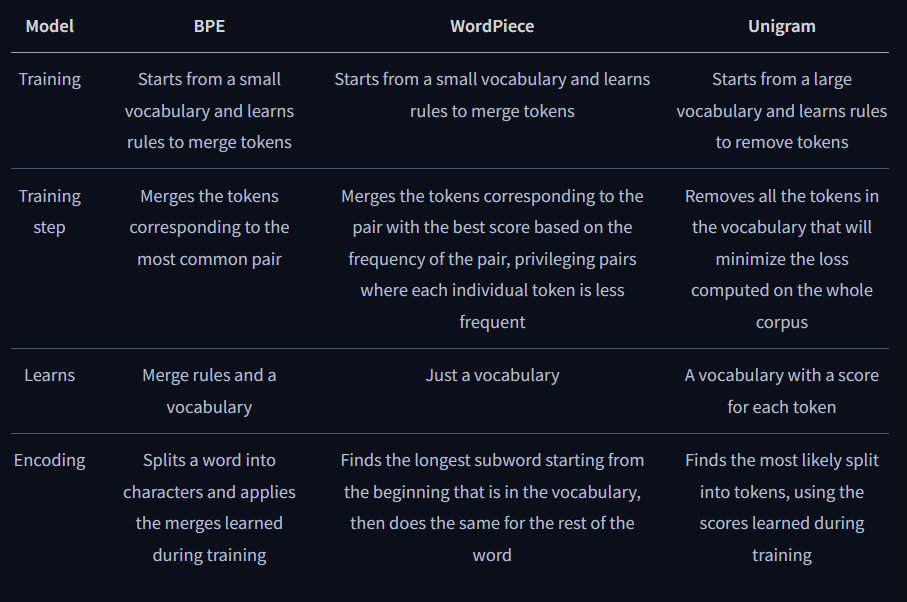

# 5. Byte-Pair Encoding tokenization

Byte-Pair Encoding (BPE) was initially developed as an algorithm to compress texts, and then used by OpenAI for tokenization when pretraining the GPT model. It’s used by a lot of Transformer models, including GPT, GPT-2, RoBERTa, BART, and DeBERTa.

💡 This section covers BPE in depth, going as far as showing a full implementation. You can skip to the end if you just want a general overview of the tokenization algorithm.



**Training algorithm**

BPE training starts by computing the unique set of words used in the corpus (after the normalization and pre-tokenization steps are completed), then building the vocabulary by taking all the symbols used to write those words. As a very simple example, let’s say our corpus uses these five words:

```
"hug", "pug", "pun", "bun", "hugs"
```

The base vocabulary will then be ["b", "g", "h", "n", "p", "s", "u"]. For real-world cases, that base vocabulary will contain all the ASCII characters, at the very least, and probably some Unicode characters as well. If an example you are tokenizing uses a character that is not in the training corpus, that character will be converted to the unknown token. That’s one reason why lots of NLP models are very bad at analyzing content with emojis, for instance.

The GPT-2 and RoBERTa tokenizers (which are pretty similar) have a clever way to deal with this: they don’t look at words as being written with Unicode characters, but with bytes. This way the base vocabulary has a small size (256), but every character you can think of will still be included and not end up being converted to the unknown token. This trick is called byte-level BPE.

After getting this base vocabulary, we add new tokens until the desired vocabulary size is reached by learning merges, which are rules to merge two elements of the existing vocabulary together into a new one. So, at the beginning these merges will create tokens with two characters, and then, as training progresses, longer subwords.

At any step during the tokenizer training, the BPE algorithm will search for the most frequent pair of existing tokens (by “pair,” here we mean two consecutive tokens in a word). That most frequent pair is the one that will be merged, and we rinse and repeat for the next step.

Going back to our previous example, let’s assume the words had the following frequencies:



```
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
```

meaning "hug" was present 10 times in the corpus, "pug" 5 times, "pun" 12 times, "bun" 4 times, and "hugs" 5 times. We start the training by splitting each word into characters (the ones that form our initial vocabulary) so we can see each word as a list of tokens:

```
("h" "u" "g", 10), ("p" "u" "g", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "u" "g" "s", 5)
```

Then we look at pairs. The pair ("h", "u") is present in the words "hug" and "hugs", so 15 times total in the corpus. It’s not the most frequent pair, though: that honor belongs to ("u", "g"), which is present in "hug", "pug", and "hugs", for a grand total of 20 times in the vocabulary.

Thus, the first merge rule learned by the tokenizer is ("u", "g") -> "ug", which means that "ug" will be added to the vocabulary, and the pair should be merged in all the words of the corpus. At the end of this stage, the vocabulary and corpus look like this:



```
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "ug"]
Corpus: ("h" "ug", 10), ("p" "ug", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "ug" "s", 5)
```
Now we have some pairs that result in a token longer than two characters: the pair ("h", "ug"), for instance (present 15 times in the corpus). The most frequent pair at this stage is ("u", "n"), however, present 16 times in the corpus, so the second merge rule learned is ("u", "n") -> "un". Adding that to the vocabulary and merging all existing occurrences leads us to:


```
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "ug", "un"]
Corpus: ("h" "ug", 10), ("p" "ug", 5), ("p" "un", 12), ("b" "un", 4), ("h" "ug" "s", 5)
```

Now the most frequent pair is ("h", "ug"), so we learn the merge rule ("h", "ug") -> "hug", which gives us our first three-letter token. After the merge, the corpus looks like this:

```
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "ug", "un", "hug"]
Corpus: ("hug", 10), ("p" "ug", 5), ("p" "un", 12), ("b" "un", 4), ("hug" "s", 5)
```
And we continue like this until we reach the desired vocabulary size.



**Tokenization algorithm**

Tokenization follows the training process closely, in the sense that new inputs are tokenized by applying the following steps:

1. Normalization
2. Pre-tokenization
3. Splitting the words into individual characters
4. Applying the merge rules learned in order on those splits

Let’s take the example we used during training, with the three merge rules learned:

```
("u", "g") -> "ug"
("u", "n") -> "un"
("h", "ug") -> "hug"
```

The word "bug" will be tokenized as ["b", "ug"]. "mug", however, will be tokenized as ["[UNK]", "ug"] since the letter "m" was not in the base vocabulary. Likewise, the word "thug" will be tokenized as ["[UNK]", "hug"]: the letter "t" is not in the base vocabulary, and applying the merge rules results first in "u" and "g" being merged and then "h" and "ug" being merged.

✏️ Now your turn! How do you think the word "unhug" will be tokenized?





**Implementing BPE**

Now let’s take a look at an implementation of the BPE algorithm. This won’t be an optimized version you can actually use on a big corpus; we just want to show you the code so you can understand the algorithm a little bit better.

First we need a corpus, so let’s create a simple one with a few sentences:

In [ ]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

Next, we need to pre-tokenize that corpus into words. Since we are replicating a BPE tokenizer (like GPT-2), we will use the gpt2 tokenizer for the pre-tokenization:



In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

Then we compute the frequencies of each word in the corpus as we do the pre-tokenization:

In [ ]:
from collections import defaultdict

word_freqs = defaultdict(int)

for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

defaultdict(<class 'int'>, {'This': 3, 'Ġis': 2, 'Ġthe': 1, 'ĠHugging': 1, 'ĠFace': 1, 'ĠCourse': 1, '.': 4, 'Ġchapter': 1, 'Ġabout': 1, 'Ġtokenization': 1, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1, 'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1, 'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})


The next step is to compute the base vocabulary, formed by all the characters used in the corpus:



In [ ]:
alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print(alphabet)

[',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


We also add the special tokens used by the model at the beginning of that vocabulary. In the case of GPT-2, the only special token is "<|endoftext|>":



In [ ]:
vocab = ["<|endoftext|>"] + alphabet.copy()

We now need to split each word into individual characters, to be able to start training:



In [ ]:
splits = {word: [c for c in word] for word in word_freqs.keys()}

Now that we are ready for training, let’s write a function that computes the frequency of each pair. We’ll need to use this at each step of the training:



In [ ]:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

Let’s have a look at a part of this dictionary after the initial splits:



In [ ]:
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('T', 'h'): 3
('h', 'i'): 3
('i', 's'): 5
('Ġ', 'i'): 2
('Ġ', 't'): 7
('t', 'h'): 3


Now, finding the most frequent pair only takes a quick loop:



In [ ]:
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

('Ġ', 't') 7


So the first merge to learn is ('Ġ', 't') -> 'Ġt', and we add 'Ġt' to the vocabulary:



In [ ]:
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

To continue, we need to apply that merge in our splits dictionary. Let’s write another function for this:



In [ ]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

And we can have a look at the result of the first merge:



In [ ]:
splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']


Now we have everything we need to loop until we have learned all the merges we want. Let’s aim for a vocab size of 50:



In [ ]:
vocab_size = 50

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

As a result, we’ve learned 19 merge rules (the initial vocabulary had a size of 31 — 30 characters in the alphabet, plus the special token):



In [ ]:
print(merges)

{('Ġ', 't'): 'Ġt', ('i', 's'): 'is', ('e', 'r'): 'er', ('Ġ', 'a'): 'Ġa', ('Ġt', 'o'): 'Ġto', ('e', 'n'): 'en', ('T', 'h'): 'Th', ('Th', 'is'): 'This', ('o', 'u'): 'ou', ('s', 'e'): 'se', ('Ġto', 'k'): 'Ġtok', ('Ġtok', 'en'): 'Ġtoken', ('n', 'd'): 'nd', ('Ġ', 'is'): 'Ġis', ('Ġt', 'h'): 'Ġth', ('Ġth', 'e'): 'Ġthe', ('i', 'n'): 'in', ('Ġa', 'b'): 'Ġab', ('Ġtoken', 'i'): 'Ġtokeni'}


And the vocabulary is composed of the special token, the initial alphabet, and all the results of the merges:



In [ ]:
print(vocab)

['<|endoftext|>', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ', 'Ġt', 'is', 'er', 'Ġa', 'Ġto', 'en', 'Th', 'This', 'ou', 'se', 'Ġtok', 'Ġtoken', 'nd', 'Ġis', 'Ġth', 'Ġthe', 'in', 'Ġab', 'Ġtokeni']


💡 Using train_new_from_iterator() on the same corpus won’t result in the exact same vocabulary. This is because when there is a choice of the most frequent pair, we selected the first one encountered, while the 🤗 Tokenizers library selects the first one based on its inner IDs.

To tokenize a new text, we pre-tokenize it, split it, then apply all the merge rules learned:

In [ ]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])

We can try this on any text composed of characters in the alphabet:



In [ ]:
tokenize("This is not a token.")

['This', 'Ġis', 'Ġ', 'n', 'o', 't', 'Ġa', 'Ġtoken', '.']

⚠️ Our implementation will throw an error if there is an unknown character since we didn’t do anything to handle them. GPT-2 doesn’t actually have an unknown token (it’s impossible to get an unknown character when using byte-level BPE), but this could happen here because we did not include all the possible bytes in the initial vocabulary. This aspect of BPE is beyond the scope of this section, so we’ve left the details out.

That’s it for the BPE algorithm! Next, we’ll have a look at WordPiece.



# 6. WordPiece tokenization

WordPiece is the tokenization algorithm Google developed to pretrain BERT. It has since been reused in quite a few Transformer models based on BERT, such as DistilBERT, MobileBERT, Funnel Transformers, and MPNET. It’s very similar to BPE in terms of the training, but the actual tokenization is done differently.

💡 This section covers WordPiece in depth, going as far as showing a full implementation. You can skip to the end if you just want a general overview of the tokenization algorithm.




**Training algorithm**

⚠️ Google never open-sourced its implementation of the training algorithm of WordPiece, so what follows is our best guess based on the published literature. It may not be 100% accurate.

Like BPE, WordPiece starts from a small vocabulary including the special tokens used by the model and the initial alphabet. Since it identifies subwords by adding a prefix (like ## for BERT), each word is initially split by adding that prefix to all the characters inside the word. So, for instance, "word" gets split like this:

```
w ##o ##r ##d
```

Thus, the initial alphabet contains all the characters present at the beginning of a word and the characters present inside a word preceded by the WordPiece prefix.

Then, again like BPE, WordPiece learns merge rules. The main difference is the way the pair to be merged is selected. Instead of selecting the most frequent pair, WordPiece computes a score for each pair, using the following formula:

$ \text{score} = \frac{\text{freq_of_pair}}{\text{freq_of_first_element} \times \text{freq_of_second_element}} $


By dividing the frequency of the pair by the product of the frequencies of each of its parts, the algorithm prioritizes the merging of pairs where the individual parts are less frequent in the vocabulary. For instance, it won’t necessarily merge ("un", "##able") even if that pair occurs very frequently in the vocabulary, because the two pairs "un" and "##able" will likely each appear in a lot of other words and have a high frequency. In contrast, a pair like ("hu", "##gging") will probably be merged faster (assuming the word “hugging” appears often in the vocabulary) since "hu" and "##gging" are likely to be less frequent individually.

Let’s look at the same vocabulary we used in the BPE training example:

```
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
```
The splits here will be:

```
("h" "##u" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("h" "##u" "##g" "##s", 5)
```

so the initial vocabulary will be ["b", "h", "p", "##g", "##n", "##s", "##u"] (if we forget about special tokens for now). The most frequent pair is ("##u", "##g") (present 20 times), but the individual frequency of "##u" is very high, so its score is not the highest (it’s 1 / 36). All pairs with a "##u" actually have that same score (1 / 36), so the best score goes to the pair ("##g", "##s") — the only one without a "##u" — at 1 / 20, and the first merge learned is ("##g", "##s") -> ("##gs").

Note that when we merge, we remove the ## between the two tokens, so we add "##gs" to the vocabulary and apply the merge in the words of the corpus:

```
Vocabulary: ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs"]
Corpus: ("h" "##u" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("h" "##u" "##gs", 5)
```
At this point, "##u" is in all the possible pairs, so they all end up with the same score. Let’s say that in this case, the first pair is merged, so ("h", "##u") -> "hu". This takes us to:

```
Vocabulary: ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs", "hu"]
Corpus: ("hu" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("hu" "##gs", 5)
```

Then the next best score is shared by ("hu", "##g") and ("hu", "##gs") (with 1/15, compared to 1/21 for all the other pairs), so the first pair with the biggest score is merged:

```
Vocabulary: ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs", "hu", "hug"]
Corpus: ("hug", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("hu" "##gs", 5)
```

and we continue like this until we reach the desired vocabulary size.




**Tokenization algorithm**

Tokenization differs in WordPiece and BPE in that WordPiece only saves the final vocabulary, not the merge rules learned. Starting from the word to tokenize, WordPiece finds the longest subword that is in the vocabulary, then splits on it. For instance, if we use the vocabulary learned in the example above, for the word "hugs" the longest subword starting from the beginning that is inside the vocabulary is "hug", so we split there and get ["hug", "##s"]. We then continue with "##s", which is in the vocabulary, so the tokenization of "hugs" is ["hug", "##s"].

With BPE, we would have applied the merges learned in order and tokenized this as ["hu", "##gs"], so the encoding is different.

As another example, let’s see how the word "bugs" would be tokenized. "b" is the longest subword starting at the beginning of the word that is in the vocabulary, so we split there and get ["b", "##ugs"]. Then "##u" is the longest subword starting at the beginning of "##ugs" that is in the vocabulary, so we split there and get ["b", "##u, "##gs"]. Finally, "##gs" is in the vocabulary, so this last list is the tokenization of "bugs".

When the tokenization gets to a stage where it’s not possible to find a subword in the vocabulary, the whole word is tokenized as unknown — so, for instance, "mug" would be tokenized as ["[UNK]"], as would "bum" (even if we can begin with "b" and "##u", "##m" is not the vocabulary, and the resulting tokenization will just be ["[UNK]"], not ["b", "##u", "[UNK]"]). This is another difference from BPE, which would only classify the individual characters not in the vocabulary as unknown.

✏️ Now your turn! How will the word "pugs" be tokenized?

**Implementing WordPiece**

Now let’s take a look at an implementation of the WordPiece algorithm. Like with BPE, this is just pedagogical, and you won’t able to use this on a big corpus.

We will use the same corpus as in the BPE example:

In [ ]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

First, we need to pre-tokenize the corpus into words. Since we are replicating a WordPiece tokenizer (like BERT), we will use the bert-base-cased tokenizer for the pre-tokenization:



In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Then we compute the frequencies of each word in the corpus as we do the pre-tokenization:



In [ ]:
from collections import defaultdict

word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

word_freqs

defaultdict(int,
            {'This': 3,
             'is': 2,
             'the': 1,
             'Hugging': 1,
             'Face': 1,
             'Course': 1,
             '.': 4,
             'chapter': 1,
             'about': 1,
             'tokenization': 1,
             'section': 1,
             'shows': 1,
             'several': 1,
             'tokenizer': 1,
             'algorithms': 1,
             'Hopefully': 1,
             ',': 1,
             'you': 1,
             'will': 1,
             'be': 1,
             'able': 1,
             'to': 1,
             'understand': 1,
             'how': 1,
             'they': 1,
             'are': 1,
             'trained': 1,
             'and': 1,
             'generate': 1,
             'tokens': 1})

As we saw before, the alphabet is the unique set composed of all the first letters of words, and all the other letters that appear in words prefixed by ##:



In [ ]:
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
alphabet

print(alphabet)

['##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y']


We also add the special tokens used by the model at the beginning of that vocabulary. In the case of BERT, it’s the list ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]:



In [ ]:
vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()

Next we need to split each word, with all the letters that are not the first prefixed by ##:



In [ ]:
splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}

Now that we are ready for training, let’s write a function that computes the score of each pair. We’ll need to use this at each step of the training:



In [ ]:
def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

Let’s have a look at a part of this dictionary after the initial splits:



In [ ]:
pair_scores = compute_pair_scores(splits)
for i, key in enumerate(pair_scores.keys()):
    print(f"{key}: {pair_scores[key]}")
    if i >= 5:
        break

('T', '##h'): 0.125
('##h', '##i'): 0.03409090909090909
('##i', '##s'): 0.02727272727272727
('i', '##s'): 0.1
('t', '##h'): 0.03571428571428571
('##h', '##e'): 0.011904761904761904


Now, finding the pair with the best score only takes a quick loop:



In [ ]:
best_pair = ""
max_score = None
for pair, score in pair_scores.items():
    if max_score is None or max_score < score:
        best_pair = pair
        max_score = score

print(best_pair, max_score)

('a', '##b') 0.2


So the first merge to learn is ('a', '##b') -> 'ab', and we add 'ab' to the vocabulary:



In [ ]:
vocab.append("ab")

To continue, we need to apply that merge in our splits dictionary. Let’s write another function for this:



In [ ]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

And we can have a look at the result of the first merge:



In [ ]:
splits = merge_pair("a", "##b", splits)
splits["about"]

['ab', '##o', '##u', '##t']

Now we have everything we need to loop until we have learned all the merges we want. Let’s aim for a vocab size of 70:



In [ ]:
vocab_size = 70
while len(vocab) < vocab_size:
    scores = compute_pair_scores(splits)
    best_pair, max_score = "", None
    for pair, score in scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
    splits = merge_pair(*best_pair, splits)
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

print(vocab)

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y', 'ab', '##fu', 'Fa', 'Fac', '##ct', '##ful', '##full', '##fully', 'Th', 'ch', '##hm', 'cha', 'chap', 'chapt', '##thm', 'Hu', 'Hug', 'Hugg', 'sh', 'th', 'is', '##thms', '##za', '##zat', '##ut']


As we can see, compared to BPE, this tokenizer learns parts of words as tokens a bit faster.

💡 Using train_new_from_iterator() on the same corpus won’t result in the exact same vocabulary. This is because the 🤗 Tokenizers library does not implement WordPiece for the training (since we are not completely sure of its internals), but uses BPE instead.

To tokenize a new text, we pre-tokenize it, split it, then apply the tokenization algorithm on each word. That is, we look for the biggest subword starting at the beginning of the first word and split it, then we repeat the process on the second part, and so on for the rest of that word and the following words in the text:

Let’s test it on one word that’s in the vocabulary, and another that isn’t:



In [ ]:
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

print(encode_word("Hugging"))
print(encode_word("HOgging"))

['Hugg', '##i', '##n', '##g']
['[UNK]']


Now, let’s write a function that tokenizes a text:



In [ ]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    encoded_words = [encode_word(word) for word in pre_tokenized_text]
    return sum(encoded_words, [])

We can try it on any text:



In [ ]:
tokenize("This is the Hugging Face course!")

['Th',
 '##i',
 '##s',
 'is',
 'th',
 '##e',
 'Hugg',
 '##i',
 '##n',
 '##g',
 'Fac',
 '##e',
 'c',
 '##o',
 '##u',
 '##r',
 '##s',
 '##e',
 '[UNK]']

That’s it for the WordPiece algorithm! Now let’s take a look at Unigram.



# 7. Unigram tokenization

The Unigram algorithm is often used in SentencePiece, which is the tokenization algorithm used by models like AlBERT, T5, mBART, Big Bird, and XLNet.

💡 This section covers Unigram in depth, going as far as showing a full implementation. You can skip to the end if you just want a general overview of the tokenization algorithm.



**Training algorithm**

Compared to BPE and WordPiece, Unigram works in the other direction: it starts from a big vocabulary and removes tokens from it until it reaches the desired vocabulary size. There are several options to use to build that base vocabulary: we can take the most common substrings in pre-tokenized words, for instance, or apply BPE on the initial corpus with a large vocabulary size.

At each step of the training, the Unigram algorithm computes a loss over the corpus given the current vocabulary. Then, for each symbol in the vocabulary, the algorithm computes how much the overall loss would increase if the symbol was removed, and looks for the symbols that would increase it the least. Those symbols have a lower effect on the overall loss over the corpus, so in a sense they are “less needed” and are the best candidates for removal.

This is all a very costly operation, so we don’t just remove the single symbol associated with the lowest loss increase, but the
𝑝
p (\(p\) being a hyperparameter you can control, usually 10 or 20) percent of the symbols associated with the lowest loss increase. This process is then repeated until the vocabulary has reached the desired size.

Note that we never remove the base characters, to make sure any word can be tokenized.

Now, this is still a bit vague: the main part of the algorithm is to compute a loss over the corpus and see how it changes when we remove some tokens from the vocabulary, but we haven’t explained how to do this yet. This step relies on the tokenization algorithm of a Unigram model, so we’ll dive into this next.

We’ll reuse the corpus from the previous examples:

```
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
```
and for this example, we will take all strict substrings for the initial vocabulary :
```
["h", "u", "g", "hu", "ug", "p", "pu", "n", "un", "b", "bu", "s", "hug", "gs", "ugs"]
```





**Tokenization algorithm**

A Unigram model is a type of language model that considers each token to be independent of the tokens before it. It’s the simplest language model, in the sense that the probability of token X given the previous context is just the probability of token X. So, if we used a Unigram language model to generate text, we would always predict the most common token.

The probability of a given token is its frequency (the number of times we find it) in the original corpus, divided by the sum of all frequencies of all tokens in the vocabulary (to make sure the probabilities sum up to 1). For instance, "ug" is present in "hug", "pug", and "hugs", so it has a frequency of 20 in our corpus.

Here are the frequencies of all the possible subwords in the vocabulary:

```
("h", 15) ("u", 36) ("g", 20) ("hu", 15) ("ug", 20) ("p", 17) ("pu", 17) ("n", 16)
("un", 16) ("b", 4) ("bu", 4) ("s", 5) ("hug", 15) ("gs", 5) ("ugs", 5)
```

So, the sum of all frequencies is 210, and the probability of the subword "ug" is thus 20/210.



To tokenize a given word using the Unigram model, we evaluate all possible segmentations into tokens and compute the probability of each according to the model. Since all tokens are considered independent, the probability of a segmentation is the product of the probabilities of each token.

For example:

- The tokenization ["p", "u", "g"] of "pug" has the probability:
  
  $
  P(["p", "u", "g"]) = P("p") \times P("u") \times P("g") = \frac{5}{210} \times \frac{36}{210} \times \frac{20}{210} = 0.000389
$

- The tokenization ["pu", "g"] has the probability:
  
  $
  P(["pu", "g"]) = P("pu") \times P("g") = \frac{5}{210} \times \frac{20}{210} = 0.0022676
$

The tokenization ["pu", "g"] is more likely.

Generally, tokenizations with the fewest tokens possible have the highest probability because each additional token involves an additional division by 210. This aligns with the intuitive goal of splitting a word into the least number of tokens possible.

Therefore, the tokenization of a word with the Unigram model is the one with the highest probability. In the example of "pug," here are the probabilities for each possible segmentation.



```
["p", "u", "g"] : 0.000389
["p", "ug"] : 0.0022676
["pu", "g"] : 0.0022676
```



The word "pug" could be tokenized as either ["p", "ug"] or ["pu", "g"], depending on which segmentation appears first, though such ties are rare in larger corpora. To find all possible segmentations and compute their probabilities, the Viterbi algorithm is used. This algorithm builds a graph where branches connect characters if the subword they form is in the vocabulary, assigning a probability to each branch.

To determine the best segmentation, the Viterbi algorithm calculates the highest scoring segmentation ending at each position in the word by considering all subwords ending at that position and using the best tokenization score from where the subword starts. The optimal path is then traced back from the end of the word. For instance, in the word "unhug," the algorithm would identify the subwords with the highest scores for each position.



```
Character 0 (u): "u" (score 0.171429)
Character 1 (n): "un" (score 0.076191)
Character 2 (h): "un" "h" (score 0.005442)
Character 3 (u): "un" "hu" (score 0.005442)
Character 4 (g): "un" "hug" (score 0.005442)
```

Thus "unhug" would be tokenized as ["un", "hug"].



**Back to training**

Now that we have seen how the tokenization works, we can dive a little more deeply into the loss used during training. At any given stage, this loss is computed by tokenizing every word in the corpus, using the current vocabulary and the Unigram model determined by the frequencies of each token in the corpus (as seen before).

Each word in the corpus has a score, and the loss is the negative log likelihood of those scores — that is, the sum for all the words in the corpus of all the -log(P(word)).

Let’s go back to our example with the following corpus:

```
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
```

The tokenization of each word with their respective scores is:

```
"hug": ["hug"] (score 0.071428)
"pug": ["pu", "g"] (score 0.007710)
"pun": ["pu", "n"] (score 0.006168)
"bun": ["bu", "n"] (score 0.001451)
"hugs": ["hug", "s"] (score 0.001701)
```
So the loss is:

```
10 * (-log(0.071428)) + 5 * (-log(0.007710)) + 12 * (-log(0.006168)) + 4 * (-log(0.001451)) + 5 * (-log(0.001701)) = 169.8
```
Now we need to compute how removing each token affects the loss. This is rather tedious, so we’ll just do it for two tokens here and save the whole process for when we have code to help us. In this (very) particular case, we had two equivalent tokenizations of all the words: as we saw earlier, for example, "pug" could be tokenized ["p", "ug"] with the same score. Thus, removing the "pu" token from the vocabulary will give the exact same loss.

On the other hand, removing "hug" will make the loss worse, because the tokenization of "hug" and "hugs" will become:

```
"hug": ["hu", "g"] (score 0.006802)
"hugs": ["hu", "gs"] (score 0.001701)
```

These changes will cause the loss to rise by:

```
- 10 * (-log(0.071428)) + 10 * (-log(0.006802)) = 23.5
```
Therefore, the token "pu" will probably be removed from the vocabulary, but not "hug".



**Implementing unigram**

Now let’s implement everything we’ve seen so far in code. Like with BPE and WordPiece, this is not an efficient implementation of the Unigram algorithm (quite the opposite), but it should help you understand it a bit better.

We will use the same corpus as before as an example:

In [2]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

This time, we will use xlnet-base-cased as our model:



In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Like for BPE and WordPiece, we begin by counting the number of occurrences of each word in the corpus:



In [4]:
from collections import defaultdict

word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

word_freqs

defaultdict(int,
            {'▁This': 3,
             '▁is': 2,
             '▁the': 1,
             '▁Hugging': 1,
             '▁Face': 1,
             '▁Course.': 1,
             '▁chapter': 1,
             '▁about': 1,
             '▁tokenization.': 1,
             '▁section': 1,
             '▁shows': 1,
             '▁several': 1,
             '▁tokenizer': 1,
             '▁algorithms.': 1,
             '▁Hopefully,': 1,
             '▁you': 1,
             '▁will': 1,
             '▁be': 1,
             '▁able': 1,
             '▁to': 1,
             '▁understand': 1,
             '▁how': 1,
             '▁they': 1,
             '▁are': 1,
             '▁trained': 1,
             '▁and': 1,
             '▁generate': 1,
             '▁tokens.': 1})

Then, we need to initialize our vocabulary to something larger than the vocab size we will want at the end. We have to include all the basic characters (otherwise we won’t be able to tokenize every word), but for the bigger substrings we’ll only keep the most common ones, so we sort them by frequency:



In [5]:
char_freqs = defaultdict(int)
subwords_freqs = defaultdict(int)
for word, freq in word_freqs.items():
    for i in range(len(word)):
        char_freqs[word[i]] += freq
        # Loop through the subwords of length at least 2
        for j in range(i + 2, len(word) + 1):
            subwords_freqs[word[i:j]] += freq

# Sort subwords by frequency
sorted_subwords = sorted(subwords_freqs.items(), key=lambda x: x[1], reverse=True)
sorted_subwords[:10]

[('▁t', 7),
 ('is', 5),
 ('er', 5),
 ('▁a', 5),
 ('▁to', 4),
 ('to', 4),
 ('en', 4),
 ('▁T', 3),
 ('▁Th', 3),
 ('▁Thi', 3)]

We group the characters with the best subwords to arrive at an initial vocabulary of size 300:



In [6]:
token_freqs = list(char_freqs.items()) + sorted_subwords[: 300 - len(char_freqs)]
token_freqs = {token: freq for token, freq in token_freqs}

💡 SentencePiece uses a more efficient algorithm called Enhanced Suffix Array (ESA) to create the initial vocabulary.

Next, we compute the sum of all frequencies, to convert the frequencies into probabilities. For our model we will store the logarithms of the probabilities, because it’s more numerically stable to add logarithms than to multiply small numbers, and this will simplify the computation of the loss of the model:

In [7]:
from math import log

total_sum = sum([freq for token, freq in token_freqs.items()])
model = {token: -log(freq / total_sum) for token, freq in token_freqs.items()}

The main function tokenizes words using the Viterbi algorithm by computing the best segmentation for each substring of a word and storing these in `best_segmentations`. Each position in the word has a dictionary with the start index of the last token and the score of the best segmentation. Two loops are used: the main loop iterates over each start position, and the inner loop checks all substrings from that position against a vocabulary. If a substring is in the vocabulary, its segmentation is compared to the current best. After processing, the function traces back from the end of the word to the start, recording the tokens.

In [8]:
def encode_word(word, model):
    best_segmentations = [{"start": 0, "score": 1}] + [
        {"start": None, "score": None} for _ in range(len(word))
    ]
    for start_idx in range(len(word)):
        # This should be properly filled by the previous steps of the loop
        best_score_at_start = best_segmentations[start_idx]["score"]
        for end_idx in range(start_idx + 1, len(word) + 1):
            token = word[start_idx:end_idx]
            if token in model and best_score_at_start is not None:
                score = model[token] + best_score_at_start
                # If we have found a better segmentation ending at end_idx, we update
                if (
                    best_segmentations[end_idx]["score"] is None
                    or best_segmentations[end_idx]["score"] > score
                ):
                    best_segmentations[end_idx] = {"start": start_idx, "score": score}

    segmentation = best_segmentations[-1]
    if segmentation["score"] is None:
        # We did not find a tokenization of the word -> unknown
        return ["<unk>"], None

    score = segmentation["score"]
    start = segmentation["start"]
    end = len(word)
    tokens = []
    while start != 0:
        tokens.insert(0, word[start:end])
        next_start = best_segmentations[start]["start"]
        end = start
        start = next_start
    tokens.insert(0, word[start:end])
    return tokens, score

We can already try our initial model on some words:



In [9]:
print(encode_word("Hopefully", model))
print(encode_word("This", model))

(['H', 'o', 'p', 'e', 'f', 'u', 'll', 'y'], 41.5157494601402)
(['This'], 6.288267030694535)


Now it’s easy to compute the loss of the model on the corpus!



In [10]:
def compute_loss(model):
    loss = 0
    for word, freq in word_freqs.items():
        _, word_loss = encode_word(word, model)
        loss += freq * word_loss
    return loss

We can check it works on the model we have:



In [11]:
compute_loss(model)

413.10377642940875

Computing the scores for each token is not very hard either; we just have to compute the loss for the models obtained by deleting each token:



In [12]:
import copy


def compute_scores(model):
    scores = {}
    model_loss = compute_loss(model)
    for token, score in model.items():
        # We always keep tokens of length 1
        if len(token) == 1:
            continue
        model_without_token = copy.deepcopy(model)
        _ = model_without_token.pop(token)
        scores[token] = compute_loss(model_without_token) - model_loss
    return scores

scores = compute_scores(model)
print(scores["ll"])
print(scores["his"])

6.376412403623874
0.0


Since "ll" is used in the tokenization of "Hopefully", and removing it will probably make us use the token "l" twice instead, we expect it will have a positive loss. "his" is only used inside the word "This", which is tokenized as itself, so we expect it to have a zero loss. Here are the results:



💡 This approach is very inefficient, so SentencePiece uses an approximation of the loss of the model without token X: instead of starting from scratch, it just replaces token X by its segmentation in the vocabulary that is left. This way, all the scores can be computed at once at the same time as the model loss.

With all of this in place, the last thing we need to do is add the special tokens used by the model to the vocabulary, then loop until we have pruned enough tokens from the vocabulary to reach our desired size:

In [13]:
percent_to_remove = 0.1
while len(model) > 100:
    scores = compute_scores(model)
    sorted_scores = sorted(scores.items(), key=lambda x: x[1])
    # Remove percent_to_remove tokens with the lowest scores.
    for i in range(int(len(model) * percent_to_remove)):
        _ = token_freqs.pop(sorted_scores[i][0])

    total_sum = sum([freq for token, freq in token_freqs.items()])
    model = {token: -log(freq / total_sum) for token, freq in token_freqs.items()}

Then, to tokenize some text, we just need to apply the pre-tokenization and then use our encode_word() function:



In [14]:
def tokenize(text, model):
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in words_with_offsets]
    encoded_words = [encode_word(word, model)[0] for word in pre_tokenized_text]
    return sum(encoded_words, [])


tokenize("This is the Hugging Face course.", model)

['▁This',
 '▁is',
 '▁the',
 '▁Hugging',
 '▁Face',
 '▁',
 'c',
 'ou',
 'r',
 's',
 'e',
 '.']

That’s it for Unigram! Hopefully by now you’re feeling like an expert in all things tokenizer.

# 8. Building a tokenizer, block by block

Reminder:
![](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter6/tokenization_pipeline-dark.svg)

The 🤗 Tokenizers library has been built to provide several options for each of those steps, which you can mix and match together. In this section we’ll see how we can build a tokenizer from scratch, as opposed to training a new tokenizer from an old one.. You’ll then be able to build any kind of tokenizer you can think of!

More precisely, the library is built around a central Tokenizer class with the building blocks regrouped in submodules:

- normalizers contains all the possible types of Normalizer you can use (complete list [here](https://huggingface.co/docs/tokenizers/api/normalizers)).
- pre_tokenizers contains all the possible types of PreTokenizer you can use (complete list [here](https://huggingface.co/docs/tokenizers/api/pre-tokenizers)).
- models contains the various types of Model you can use, like BPE, WordPiece, and Unigram (complete list [here](https://huggingface.co/docs/tokenizers/api/models)).
- trainers contains all the different types of Trainer you can use to train your model on a corpus (one per type of model; complete list [here](https://huggingface.co/docs/tokenizers/api/trainers)).
- post_processors contains the various types of PostProcessor you can use (complete list [here](https://huggingface.co/docs/tokenizers/api/post-processors)).
- decoders contains the various types of Decoder you can use to decode the outputs of tokenization (complete list [here](https://huggingface.co/docs/tokenizers/components#decoders)).

You can find the whole list of building blocks [here](https://huggingface.co/docs/tokenizers/components).

**Acquiring a corpus**

To train our new tokenizer, we will use a small corpus of text (so the examples run fast). The steps for acquiring the corpus are similar to the ones we took at the beginning of this chapter, but this time we’ll use the WikiText-2 dataset:

In [15]:
from datasets import load_dataset

dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split="train")


def get_training_corpus():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

The function get_training_corpus() is a generator that will yield batches of 1,000 texts, which we will use to train the tokenizer.

🤗 Tokenizers can also be trained on text files directly. Here’s how we can generate a text file containing all the texts/inputs from WikiText-2 that we can use locally:

In [16]:
with open("wikitext-2.txt", "w", encoding="utf-8") as f:
    for i in range(len(dataset)):
        f.write(dataset[i]["text"] + "\n")

Next we’ll show you how to build your own BERT, GPT-2, and XLNet tokenizers, block by block. That will give us an example of each of the three main tokenization algorithms: WordPiece, BPE, and Unigram. Let’s start with BERT!



**Building a WordPiece tokenizer from scratch**

To build a tokenizer with the 🤗 Tokenizers library, we start by instantiating a Tokenizer object with a model, then set its normalizer, pre_tokenizer, post_processor, and decoder attributes to the values we want.

For this example, we’ll create a Tokenizer with a WordPiece model:

In [17]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

We have to specify the unk_token so the model knows what to return when it encounters characters it hasn’t seen before. Other arguments we can set here include the vocab of our model (we’re going to train the model, so we don’t need to set this) and max_input_chars_per_word, which specifies a maximum length for each word (words longer than the value passed will be split).

The first step of tokenization is normalization, so let’s begin with that. Since BERT is widely used, there is a BertNormalizer with the classic options we can set for BERT: lowercase and strip_accents, which are self-explanatory; clean_text to remove all control characters and replace repeating spaces with a single one; and handle_chinese_chars, which places spaces around Chinese characters. To replicate the bert-base-uncased tokenizer, we can just set this normalizer:

In [18]:
tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)

Generally speaking, however, when building a new tokenizer you won’t have access to such a handy normalizer already implemented in the 🤗 Tokenizers library — so let’s see how to create the BERT normalizer by hand. The library provides a Lowercase normalizer and a StripAccents normalizer, and you can compose several normalizers using a Sequence:



In [19]:
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

We’re also using an NFD Unicode normalizer, as otherwise the StripAccents normalizer won’t properly recognize the accented characters and thus won’t strip them out.

As we’ve seen before, we can use the normalize_str() method of the normalizer to check out the effects it has on a given text:

In [20]:
print(tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

hello how are u?


> To go further If you test the two versions of the previous normalizers on a string containing the unicode character u"\u0085" you will surely notice that these two normalizers are not exactly equivalent. To not over-complicate the version with normalizers.Sequence too much , we haven’t included the Regex replacements that the BertNormalizer requires when the clean_text argument is set to True - which is the default behavior. But don’t worry: it is possible to get exactly the same normalization without using the handy BertNormalizer by adding two normalizers.Replace’s to the normalizers sequence.

Next is the pre-tokenization step. Again, there is a prebuilt BertPreTokenizer that we can use:



In [21]:
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()

Or we can build it from scratch:



In [22]:
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

Note that the Whitespace pre-tokenizer splits on whitespace and all characters that are not letters, digits, or the underscore character, so it technically splits on whitespace and punctuation:



In [23]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[('Let', (0, 3)),
 ("'", (3, 4)),
 ('s', (4, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre', (14, 17)),
 ('-', (17, 18)),
 ('tokenizer', (18, 27)),
 ('.', (27, 28))]

If you only want to split on whitespace, you should use the WhitespaceSplit pre-tokenizer instead:



In [24]:
pre_tokenizer = pre_tokenizers.WhitespaceSplit()
pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[("Let's", (0, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre-tokenizer.', (14, 28))]

Like with normalizers, you can use a Sequence to compose several pre-tokenizers:



In [25]:
pre_tokenizer = pre_tokenizers.Sequence(
    [pre_tokenizers.WhitespaceSplit(), pre_tokenizers.Punctuation()]
)
pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[('Let', (0, 3)),
 ("'", (3, 4)),
 ('s', (4, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre', (14, 17)),
 ('-', (17, 18)),
 ('tokenizer', (18, 27)),
 ('.', (27, 28))]

The next step in the tokenization pipeline is running the inputs through the model. We already specified our model in the initialization, but we still need to train it, which will require a WordPieceTrainer. The main thing to remember when instantiating a trainer in 🤗 Tokenizers is that you need to pass it all the special tokens you intend to use — otherwise it won’t add them to the vocabulary, since they are not in the training corpus:



In [26]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)

As well as specifying the vocab_size and special_tokens, we can set the min_frequency (the number of times a token must appear to be included in the vocabulary) or change the continuing_subword_prefix (if we want to use something different from ##).

To train our model using the iterator we defined earlier, we just have to execute this command:

In [27]:
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

We can also use text files to train our tokenizer, which would look like this (we reinitialize the model with an empty WordPiece beforehand):



In [28]:
tokenizer.model = models.WordPiece(unk_token="[UNK]")
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

In both cases, we can then test the tokenizer on a text by calling the encode() method:



In [29]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '.']


The encoding obtained is an Encoding, which contains all the necessary outputs of the tokenizer in its various attributes: ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, and overflowing.

The last step in the tokenization pipeline is post-processing. We need to add the [CLS] token at the beginning and the [SEP] token at the end (or after each sentence, if we have a pair of sentences). We will use a TemplateProcessor for this, but first we need to know the IDs of the [CLS] and [SEP] tokens in the vocabulary:

In [30]:
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")
print(cls_token_id, sep_token_id)

2 3


To write the template for the TemplateProcessor, we have to specify how to treat a single sentence and a pair of sentences. For both, we write the special tokens we want to use; the first (or single) sentence is represented by $A, while the second sentence (if encoding a pair) is represented by $B. For each of these (special tokens and sentences), we also specify the corresponding token type ID after a colon.

The classic BERT template is thus defined as follows:

In [31]:
tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[("[CLS]", cls_token_id), ("[SEP]", sep_token_id)],
)

Note that we need to pass along the IDs of the special tokens, so the tokenizer can properly convert them to their IDs.

Once this is added, going back to our previous example will give:

In [32]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['[CLS]', 'let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '.', '[SEP]']


And on a pair of sentences, we get the proper result:



In [33]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences.")
print(encoding.tokens)
print(encoding.type_ids)

['[CLS]', 'let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '...', '[SEP]', 'on', 'a', 'pair', 'of', 'sentences', '.', '[SEP]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


We’ve almost finished building this tokenizer from scratch — the last step is to include a decoder:



In [34]:
tokenizer.decoder = decoders.WordPiece(prefix="##")

Let’s test it on our previous encoding:



In [35]:
tokenizer.decode(encoding.ids)

"let ' s test this tokenizer... on a pair of sentences."

Great! We can save our tokenizer in a single JSON file like this:



In [36]:
tokenizer.save("tokenizer.json")

We can then reload that file in a Tokenizer object with the from_file() method:



In [37]:
new_tokenizer = Tokenizer.from_file("tokenizer.json")

To use this tokenizer in 🤗 Transformers, we have to wrap it in a PreTrainedTokenizerFast. We can either use the generic class or, if our tokenizer corresponds to an existing model, use that class (here, BertTokenizerFast). If you apply this lesson to build a brand new tokenizer, you will have to use the first option.

To wrap the tokenizer in a PreTrainedTokenizerFast, we can either pass the tokenizer we built as a tokenizer_object or pass the tokenizer file we saved as tokenizer_file. The key thing to remember is that we have to manually set all the special tokens, since that class can’t infer from the tokenizer object which token is the mask token, the [CLS] token, etc.:

In [38]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    # tokenizer_file="tokenizer.json", # You can load from the tokenizer file, alternatively
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

If you are using a specific tokenizer class (like BertTokenizerFast), you will only need to specify the special tokens that are different from the default ones (here, none):



In [39]:
from transformers import BertTokenizerFast

wrapped_tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)

You can then use this tokenizer like any other 🤗 Transformers tokenizer. You can save it with the save_pretrained() method, or upload it to the Hub with the push_to_hub() method.

Now that we’ve seen how to build a WordPiece tokenizer, let’s do the same for a BPE tokenizer. We’ll go a bit faster since you know all the steps, and only highlight the differences.

**Building a BPE tokenizer from scratch**

Let’s now build a GPT-2 tokenizer. Like for the BERT tokenizer, we start by initializing a Tokenizer with a BPE model:

In [40]:
tokenizer = Tokenizer(models.BPE())

Also like for BERT, we could initialize this model with a vocabulary if we had one (we would need to pass the vocab and merges in this case), but since we will train from scratch, we don’t need to do that. We also don’t need to specify an unk_token because GPT-2 uses byte-level BPE, which doesn’t require it.

GPT-2 does not use a normalizer, so we skip that step and go directly to the pre-tokenization:

In [41]:
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

The option we added to ByteLevel here is to not add a space at the beginning of a sentence (which is the default otherwise). We can have a look at the pre-tokenization of an example text like before:



In [42]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test pre-tokenization!")

[('Let', (0, 3)),
 ("'s", (3, 5)),
 ('Ġtest', (5, 10)),
 ('Ġpre', (10, 14)),
 ('-', (14, 15)),
 ('tokenization', (15, 27)),
 ('!', (27, 28))]

Next is the model, which needs training. For GPT-2, the only special token is the end-of-text token:



In [43]:
trainer = trainers.BpeTrainer(vocab_size=25000, special_tokens=["<|endoftext|>"])
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

Like with the WordPieceTrainer, as well as the vocab_size and special_tokens, we can specify the min_frequency if we want to, or if we have an end-of-word suffix (like </w>), we can set it with end_of_word_suffix.

This tokenizer can also be trained on text files:

In [44]:
tokenizer.model = models.BPE()
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

Let’s have a look at the tokenization of a sample text:



In [45]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['L', 'et', "'", 's', 'Ġtest', 'Ġthis', 'Ġto', 'ken', 'izer', '.']


We apply the byte-level post-processing for the GPT-2 tokenizer as follows:



In [46]:
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)

The trim_offsets = False option indicates to the post-processor that we should leave the offsets of tokens that begin with ‘Ġ’ as they are: this way the start of the offsets will point to the space before the word, not the first character of the word (since the space is technically part of the token). Let’s have a look at the result with the text we just encoded, where 'Ġtest' is the token at index 4:



In [47]:
sentence = "Let's test this tokenizer."
encoding = tokenizer.encode(sentence)
start, end = encoding.offsets[4]
sentence[start:end]

' test'

Finally, we add a byte-level decoder:



In [48]:
tokenizer.decoder = decoders.ByteLevel()

and we can double-check it works properly:



In [49]:
tokenizer.decode(encoding.ids)

"Let's test this tokenizer."

Great! Now that we’re done, we can save the tokenizer like before, and wrap it in a PreTrainedTokenizerFast or GPT2TokenizerFast if we want to use it in 🤗 Transformers:

In [50]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token="<|endoftext|>",
    eos_token="<|endoftext|>",
)

or:



In [51]:
from transformers import GPT2TokenizerFast

wrapped_tokenizer = GPT2TokenizerFast(tokenizer_object=tokenizer)

As the last example, we’ll show you how to build a Unigram tokenizer from scratch.



**Building a Unigram tokenizer from scratch**

Let’s now build an XLNet tokenizer. Like for the previous tokenizers, we start by initializing a Tokenizer with a Unigram model:



In [52]:
tokenizer = Tokenizer(models.Unigram())

Again, we could initialize this model with a vocabulary if we had one.

For the normalization, XLNet uses a few replacements (which come from SentencePiece):

In [53]:
from tokenizers import Regex

tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),
        normalizers.NFKD(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)

This replaces “ and ” with ” and any sequence of two or more spaces with a single space, as well as removing the accents in the texts to tokenize.

The pre-tokenizer to use for any SentencePiece tokenizer is Metaspace:

In [54]:
tokenizer.pre_tokenizer = pre_tokenizers.Metaspace()

We can have a look at the pre-tokenization of an example text like before:



In [55]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test the pre-tokenizer!")

[("▁Let's", (0, 5)),
 ('▁test', (5, 10)),
 ('▁the', (10, 14)),
 ('▁pre-tokenizer!', (14, 29))]

Next is the model, which needs training. XLNet has quite a few special tokens:



In [56]:
special_tokens = ["<cls>", "<sep>", "<unk>", "<pad>", "<mask>", "<s>", "</s>"]
trainer = trainers.UnigramTrainer(
    vocab_size=25000, special_tokens=special_tokens, unk_token="<unk>"
)
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

A very important argument not to forget for the UnigramTrainer is the unk_token. We can also pass along other arguments specific to the Unigram algorithm, such as the shrinking_factor for each step where we remove tokens (defaults to 0.75) or the max_piece_length to specify the maximum length of a given token (defaults to 16).

This tokenizer can also be trained on text files:

In [57]:
tokenizer.model = models.Unigram()
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

In [58]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['▁Let', "'", 's', '▁test', '▁this', '▁to', 'ken', 'izer', '.']


A peculiarity of XLNet is that it puts the <cls> token at the end of the sentence, with a type ID of 2 (to distinguish it from the other tokens). It’s padding on the left, as a result. We can deal with all the special tokens and token type IDs with a template, like for BERT, but first we have to get the IDs of the <cls> and <sep> tokens:



In [59]:
cls_token_id = tokenizer.token_to_id("<cls>")
sep_token_id = tokenizer.token_to_id("<sep>")
print(cls_token_id, sep_token_id)

0 1


The template looks like this:



In [60]:
tokenizer.post_processor = processors.TemplateProcessing(
    single="$A:0 <sep>:0 <cls>:2",
    pair="$A:0 <sep>:0 $B:1 <sep>:1 <cls>:2",
    special_tokens=[("<sep>", sep_token_id), ("<cls>", cls_token_id)],
)

And we can test it works by encoding a pair of sentences:



In [61]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences!")
print(encoding.tokens)
print(encoding.type_ids)

['▁Let', "'", 's', '▁test', '▁this', '▁to', 'ken', 'izer', '.', '.', '.', '<sep>', '▁', 'on', '▁', 'a', '▁pair', '▁of', '▁sentence', 's', '!', '<sep>', '<cls>']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]


Finally, we add a Metaspace decoder:



In [62]:
tokenizer.decoder = decoders.Metaspace()

and we’re done with this tokenizer! We can save the tokenizer like before, and wrap it in a PreTrainedTokenizerFast or XLNetTokenizerFast if we want to use it in 🤗 Transformers. One thing to note when using PreTrainedTokenizerFast is that on top of the special tokens, we need to tell the 🤗 Transformers library to pad on the left:



In [63]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
    cls_token="<cls>",
    sep_token="<sep>",
    mask_token="<mask>",
    padding_side="left",
)

Or alternatively:



In [64]:
from transformers import XLNetTokenizerFast

wrapped_tokenizer = XLNetTokenizerFast(tokenizer_object=tokenizer)

Now that you have seen how the various building blocks are used to build existing tokenizers, you should be able to write any tokenizer you want with the 🤗 Tokenizers library and be able to use it in 🤗 Transformers.